# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import csv

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'data/train.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train_raw, y_train = train['features'], train['labels']
X_test_raw, y_test = test['features'], test['labels']


# Read Classes 
reader = list(csv.DictReader(open("signnames.csv")))
label_dict = {}
for row in reader:
    label_dict[row['ClassId']]=row['SignName']


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = X_train_raw.shape[0]

# TODO: Number of testing examples.
n_test = X_test_raw.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = [32,32]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(label_dict.keys())

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = [32, 32]
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

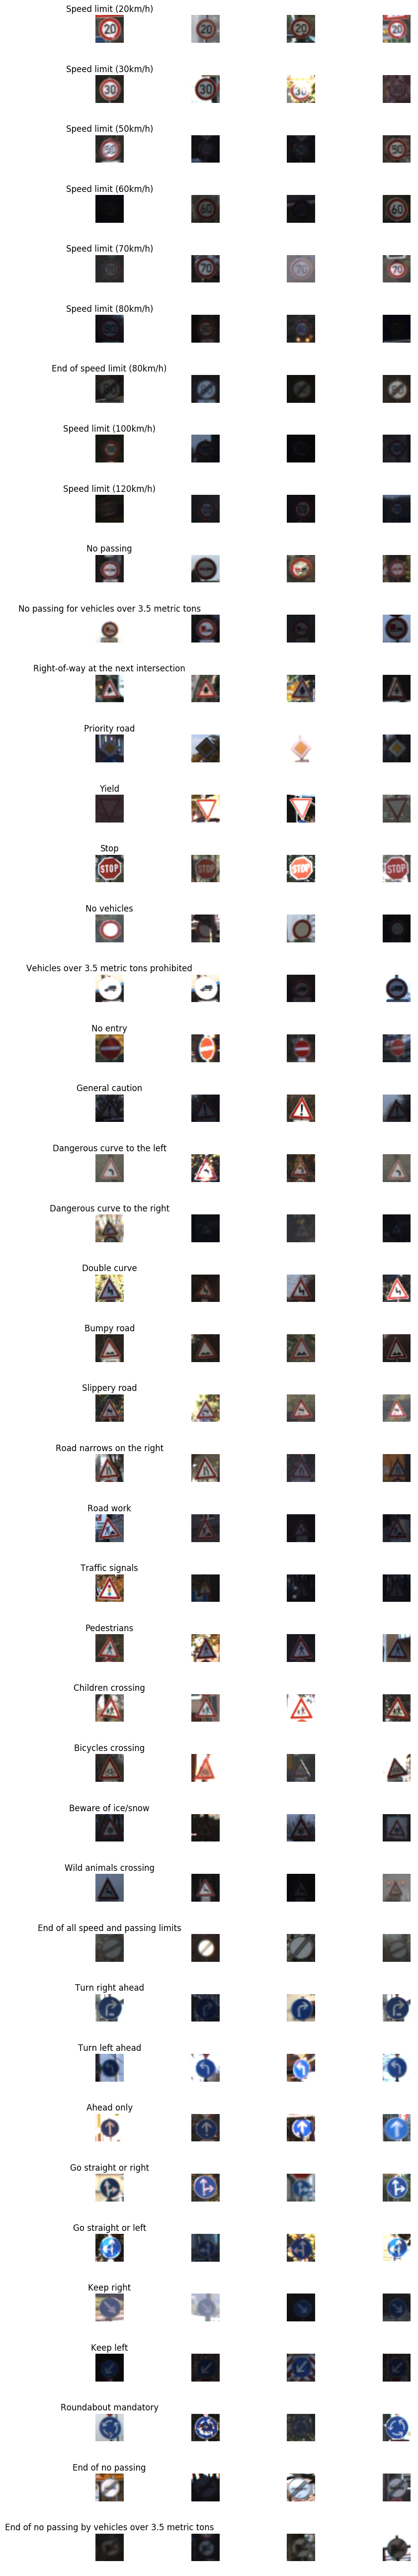

In [5]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import random
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline


def visualize(inputs,labels):
    
    n_samples = 4

    fig,axes = plt.subplots(n_classes, n_samples, figsize=(8,52))
    fig.subplots_adjust(hspace=0.3, wspace=0.05)

    for key,value in label_dict.items():
        row = int(key)
        signs = list(filter(lambda x: x[0] == row, zip(labels,inputs)))
        axes[row,0].set_title(value)
        for i in range(0,n_samples):
            sign = random.choice(signs)
            #axes[row,i].title("Sign:",value)
            axes[row,i].axis('off')
            axes[row,i].imshow(sign[1])

    fig.tight_layout()    
    plt.show()

visualize(X_train_raw,y_train)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [3]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
import cv2
import numpy as np
from scipy import ndimage


def remove_noise(inputs):
    gray_input = []
    for img in inputs: 
        
        img_merge = ndimage.median_filter(img, 3)
         
        gray_input.append(img_merge)
    
    return gray_input

def local_normalize_histogram(inputs):
    gray_input = []
    for img in inputs: 
        
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        
        b = clahe.apply(img[:,:,0])
        g = clahe.apply(img[:,:,1])
        r = clahe.apply(img[:,:,2])
    
        
        img_merge = cv2.merge((b,g,r))
         
        gray_input.append(img_merge)
    
    return gray_input
    
    

def to_bw(inputs):
    gray_input = []
    for img in inputs: 
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
        gray_img = gray_img[:,:,0]
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
        gray_img = clahe.apply(gray_img)
        gray_img_tf =  gray_img[:, :, np.newaxis]
        gray_input.append(gray_img_tf)
    
    return gray_input

def append_intensity_layer(inputs):
    gray_input = []
    for img in inputs: 
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
        
        b = img[:,:,0]
        g = img[:,:,1]
        r = img[:,:,2]
        i = gray_img[:,:,0]
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
        il = clahe.apply(i)

        img_merge = cv2.merge((b,g,r,il))
         
        gray_input.append(img_merge)
    
    return gray_input

def to_yuv(inputs):
    gray_input = []
    for img in inputs: 
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
        
        y = img[:,:,0]
        cr = img[:,:,1]
        cb = img[:,:,2]
        
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
        yl = clahe.apply(y)
        
        img_merge = cv2.merge((yl,cr,cb))
         
        gray_input.append(img_merge)
    
    return gray_input

def illumination_correction(inputs):
    gray_input = []
    for img in inputs: 
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        
        l = img[:,:,0]
        a = img[:,:,1]
        b = img[:,:,2]
        
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        cl = clahe.apply(l)
        
        img_merge = cv2.merge((cl,a,b))
         
        gray_input.append(img_merge)
    
    return gray_input


X_train = X_train_raw
X_test = X_test_raw
#X_train = remove_noise(X_train_raw)
#X_test = remove_noise(X_test_raw)
#X_train = to_bw(X_train_raw)
#X_test = to_bw(X_test_raw)

#X_train = append_intensity_layer(X_train_raw)
#X_test = append_intensity_layer(X_test_raw)
#X_train = to_yuv(X_train_raw)
#X_test = to_yuv(X_test_raw)
#X_train = illumination_correction(X_train_raw)
#X_test = illumination_correction(X_test_raw)

#X_train = local_normalize_histogram(X_train_raw)
#X_test = local_normalize_histogram(X_test_raw)


#visualize(X_train,y_train)

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

In [4]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
import cv2
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from scipy import ndimage 

def rotate(img,rotation=0.):
    rows = img.shape[0]
    cols = img.shape[1]

    M = cv2.getRotationMatrix2D((cols/2,rows/2),rotation,1)
    dst = cv2.warpAffine(img,M,(cols,rows))
    return dst

def translate(img,dx,dy):
    rows = img.shape[0]
    cols = img.shape[1]

    M = np.float32([[1,0,dx],[0,1,dy]])
    dst = cv2.warpAffine(img,M,(cols,rows))
    return dst
def randomize_img(img):
    rows = img.shape[0]
    cols = img.shape[1]

    # translate
    Mt = np.float32([[1,0,random.gauss(0,5)],[0,1,random.gauss(0,5)]])
    # rotation
    Mr = M = cv2.getRotationMatrix2D((cols/2,rows/2),random.gauss(0,2),1)
    
    M = np.matmul(Mt,Mr)
    dst = cv2.warpAffine(img,M,(cols,rows))
    return dst
    

X_train_set, X_validation, y_train_set, y_validation = train_test_split(list(X_train),list(y_train), test_size=0.15, random_state=0)

idx = np.random.choice(np.arange(len(X_train_set)), 5000, replace=False)

for i in range(0,len(idx)):
    img_copy = X_train_set[i].copy()
    img_copy = ndimage.rotate(img_copy,random.gauss(0,5),reshape=False)
    #img_copy = ndimage.median_filter(img_copy, 3)
    X_train_set.append(img_copy)
    y_train_set.append(y_train_set[i])


print("Number of training examples =", len(X_train_set))
print("Number of validation examples =", len(X_validation))
print("Number of testing examples =", len(X_test))

X_train_set,y_train_set = shuffle(X_train_set,y_train_set)


Number of training examples = 38327
Number of validation examples = 5882
Number of testing examples = 12630


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

In [5]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

import tensorflow as tf
from tensorflow.contrib.layers import flatten

EPOCHS = 20
BATCH_SIZE = 512
n_featuremaps = X_train[0].shape[2]

rate = 0.001


def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    x = tf.nn.bias_add(x, b)
    return tf.nn.tanh(x)


def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='SAME')

def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.05
    
    layer_depth = {
    'layer_1': 50,
    'layer_2': 100,
    'layer_3' : 400,
    'layer_4' : 200,
    'out' : n_classes    
    }

    # Store layers weight & bias
    weights = {
        'layer_1': tf.Variable(tf.truncated_normal(
            shape=(5, 5, n_featuremaps, layer_depth['layer_1']),mean=mu,stddev=sigma)),
        'layer_2': tf.Variable(tf.truncated_normal(
            shape=(5, 5, layer_depth['layer_1'], layer_depth['layer_2']),mean=mu,stddev=sigma)),
        'layer_3': tf.Variable(tf.truncated_normal(
            shape=(5*5*layer_depth['layer_2'], layer_depth['layer_3']),mean=mu,stddev=sigma)),
        'layer_4': tf.Variable(tf.truncated_normal(
            shape=(layer_depth['layer_3'], layer_depth['layer_4']),mean=mu,stddev=sigma)),
        'out': tf.Variable(tf.truncated_normal(
            shape=(layer_depth['layer_4'], layer_depth['out']),mean=mu,stddev=sigma))
    }
    biases = {
        'layer_1': tf.Variable(tf.zeros(layer_depth['layer_1'])),
        'layer_2': tf.Variable(tf.zeros(layer_depth['layer_2'])),
        'layer_3': tf.Variable(tf.zeros(layer_depth['layer_3'])),
        'layer_4': tf.Variable(tf.zeros(layer_depth['layer_4'])),
        'out': tf.Variable(tf.zeros(layer_depth['out']))
    }

    
    # Layer 1: Convolutional. 
    layer_1 = conv2d(x,weights['layer_1'],biases['layer_1'])

    # Pooling.
    layer_1 = maxpool2d(layer_1)

    # Layer 2: Convolutional. Output = 10x10x32.   
    layer_2 = conv2d(layer_1,weights['layer_2'],biases['layer_2'])

    # Pooling.
    layer_2 = maxpool2d(layer_2)

    # Flatten.
    fc1 = flatten(layer_2)
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    layer_3 = tf.add(tf.matmul(fc1,weights['layer_3']),biases['layer_3'])                           
    # TODO: Activation.
    layer_3 = tf.nn.tanh(layer_3)  
    
    #layer_3 = tf.nn.dropout(layer_3,0.75)
     
    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    layer_4 = tf.add(tf.matmul(layer_3,weights['layer_4']),biases['layer_4']) 
    # TODO: Activation.
    layer_4 = tf.nn.tanh(layer_4) 
    
   
    logits = tf.add(tf.matmul(layer_4,weights['out']),biases['out'])                   
                               
    return logits


x = tf.placeholder(tf.float32, (None, 32, 32, n_featuremaps))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate = rate)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [6]:
### Train your model here.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_set)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train_set, y_train_set)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_set[offset:end], y_train_set[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    saver.save(sess, 'lenet')
    print("Model saved")
    print("Testing..")
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    


Training...

EPOCH 1 ...
Validation Accuracy = 0.949

EPOCH 2 ...
Validation Accuracy = 0.985

EPOCH 3 ...
Validation Accuracy = 0.988

EPOCH 4 ...
Validation Accuracy = 0.991

EPOCH 5 ...
Validation Accuracy = 0.991

EPOCH 6 ...
Validation Accuracy = 0.994

EPOCH 7 ...
Validation Accuracy = 0.994

EPOCH 8 ...
Validation Accuracy = 0.995

EPOCH 9 ...
Validation Accuracy = 0.995

EPOCH 10 ...
Validation Accuracy = 0.994

EPOCH 11 ...
Validation Accuracy = 0.995

EPOCH 12 ...
Validation Accuracy = 0.995

EPOCH 13 ...
Validation Accuracy = 0.995

EPOCH 14 ...
Validation Accuracy = 0.995

EPOCH 15 ...
Validation Accuracy = 0.995

EPOCH 16 ...
Validation Accuracy = 0.995

EPOCH 17 ...
Validation Accuracy = 0.995

EPOCH 18 ...
Validation Accuracy = 0.995

EPOCH 19 ...
Validation Accuracy = 0.995

EPOCH 20 ...
Validation Accuracy = 0.995

Model saved
Testing..
Test Accuracy = 0.965


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

Here are the steps I took; 

Config:
    mu = 0
    sigma = 0.1
    learning_rate = 0.001
    layer_depth = {
    'layer_1': 6,
    'layer_2': 16,
    'layer_3' : 120,
    'layer_4' : 80,
    'out' : n_classes    
    }


1. LeNet mode, no processing, 40% validation
Training accuracy 0.944 - converging slowly. Likely wouldn't exceed 95%
Test Accuracy = 0.857


2. LeNet mode, B/W source, 40% validation
Training accuracy 0.958 - converging slowly. Likely wouldn't exceed 96%
Test Accuracy = 0.890

(20 epoch)
Validation Accuracy = 0.953
Test Accuracy = 0.873

(tanh vs relu)
Validation Accuracy = 0.969
Test Accuracy = 0.917

(gradient descent)
Stopped after 20, slow convergence
Validation Accuracy = 0.838
Test Accuracy = 0.796

(batch 256)
Validation Accuracy = 0.956
Test Accuracy = 0.889

Note: B/w did not seem to improve accuracy, but it did improve the speed considerably. Holding the images as B/W and adjusting the other parameters might save processing time. 




3. LeNet mode, B/W source, 40% validation - Adding 25% Dropout on layer 3
Validation Accuracy = 0.922
Test Accuracy = 0.854

4. LeNet mode, B/W source, 40% validation
Validation Accuracy = 0.944
Test Accuracy = 0.863
Config:
    mu = 0
    sigma = 0.1
    learning_rate = 0.001
    layer_depth = {
    'layer_1': 32,
    'layer_2': 64,
    'layer_3' : 120,
    'layer_4' : 80,
    'out' : n_classes    
    }
    
Very little change increasing the convolution filters. 


5. LeNet Mode, YUV (Y-Channel only), 40% Validation
Config:
    mu = 0
    sigma = 0.1
    learning_rate = 0.001
    layer_depth = {
    'layer_1': 6,
    'layer_2': 16,
    'layer_3' : 120,
    'layer_4' : 80,
    'out' : n_classes    
    }
    
(tanh) (20 epochs - roughly the same for 40 epochs) 
Validation Accuracy = 0.949
Test Accuracy = 0.884

6. LeNet, color, 40% validation
(tanh)(40 epochs)
Validation Accuracy = 0.967
Test Accuracy = 0.906


7. LeNet, color, 40% validation
   mu = 0
    sigma = 0.1
    
    layer_depth = {
    'layer_1': 16,
    'layer_2': 38,
    'layer_3' : 400,
    'layer_4' : 200,
    'out' : n_classes    
    }

Validation Accuracy = 0.973
Test Accuracy = 0.914

(0.25 dropout)
Validation Accuracy = 0.979
Test Accuracy = 0.932

(appending intensity layer , 0.25 dropout)
Validation Accuracy = 0.965
Test Accuracy = 0.914

(yuv contrast , 0.25 dropout)
Validation Accuracy = 0.967
Test Accuracy = 0.914


8. LeNet, color, 25% validation
epochs 25
batch 512
mu = 0
    sigma = 0.05
    
    layer_depth = {
    'layer_1': 50,
    'layer_2': 100,
    'layer_3' : 400,
    'layer_4' : 200,
    'out' : n_classes    
    }
Validation Accuracy = 0.995
Test Accuracy = 0.972

(dropout 0.25)
Validation Accuracy = 0.984
Test Accuracy = 0.942

(B/w)
Validation Accuracy = 0.992
Test Accuracy = 0.961

(yuv contrast)
Validation Accuracy = 0.992
Test Accuracy = 0.948










---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

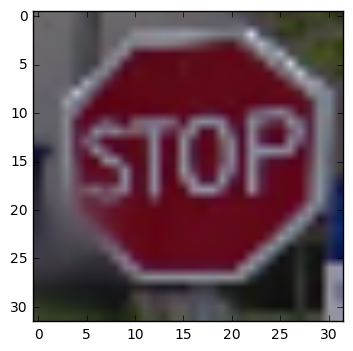

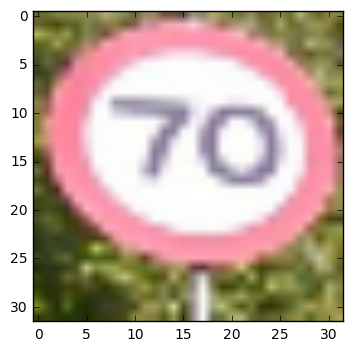

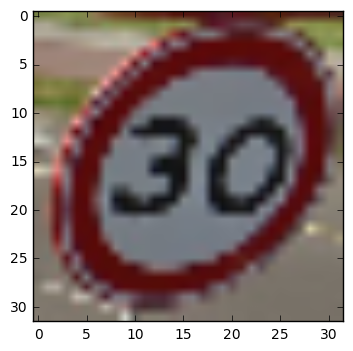

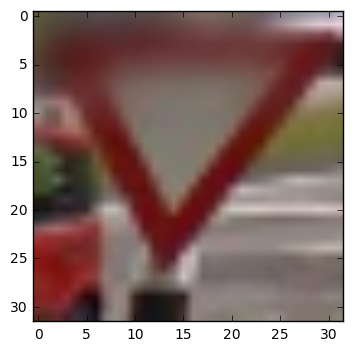

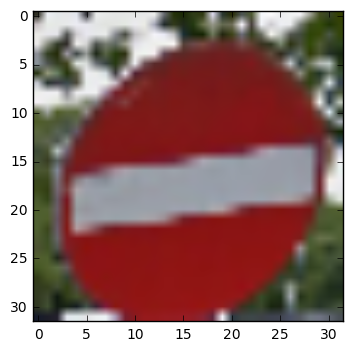

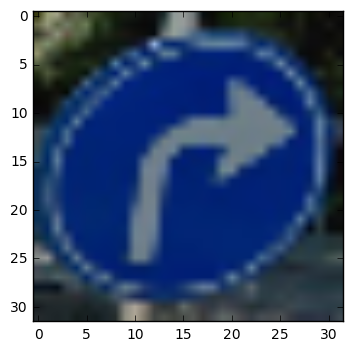

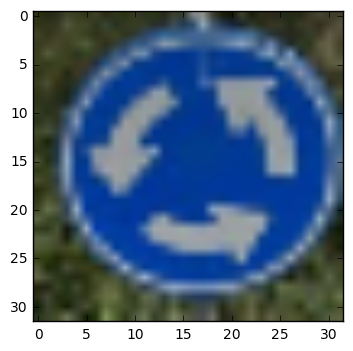

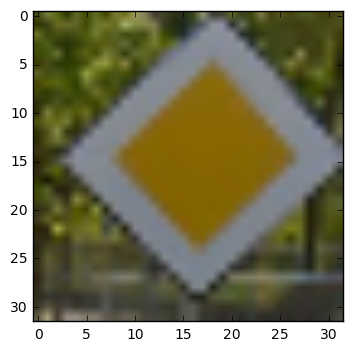

In [7]:

### Load the images and plot them here.
### Feel free to use as many code cells as needed.
from os import listdir
from os.path import isfile, join
import numpy
import cv2
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline


def load_images():
    testpath='test_images/'
    onlyfiles = [ f for f in listdir(testpath) if isfile(join(testpath,f)) ]
    images = numpy.empty(len(onlyfiles), dtype=object)
    for n in range(0, len(onlyfiles)):
        img = cv2.imread( join(testpath,onlyfiles[n]) )
        img = cv2.resize(img, (32,32)) 
        img = img[:,:,::-1]
        images[n] = img
    return images


def visualize_test(inputs):

    for index,img in enumerate(inputs):
        plt.figure(index+1)
        plt.imshow(img)
        
    
    plt.show()


X_sample = load_images()
visualize_test(X_sample)


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

Prediction Ids: [14  4  1 13 17 33 40 12]


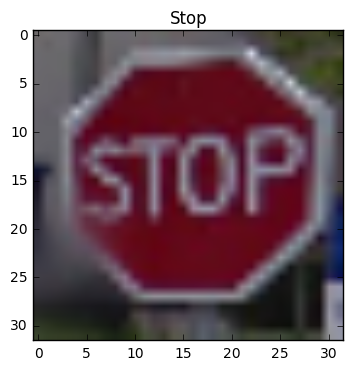

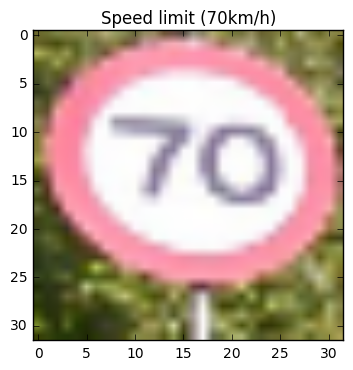

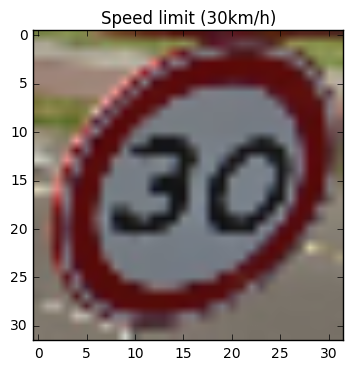

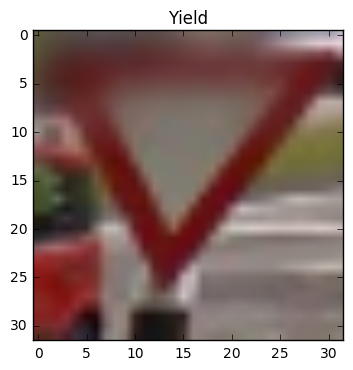

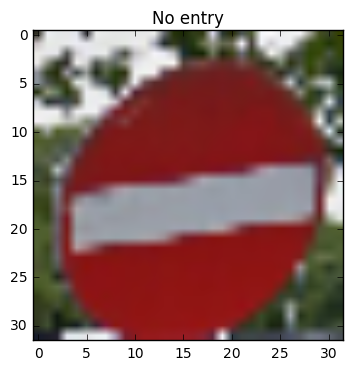

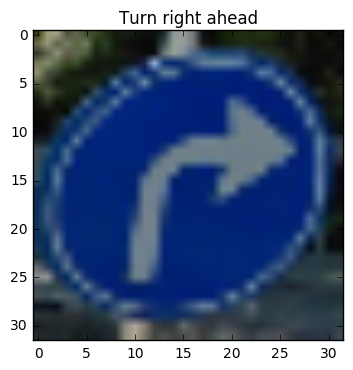

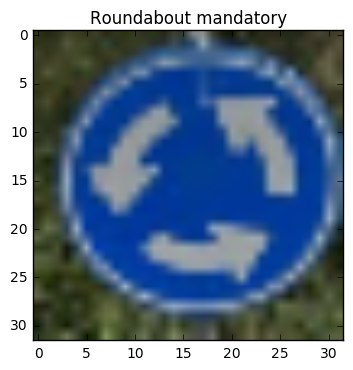

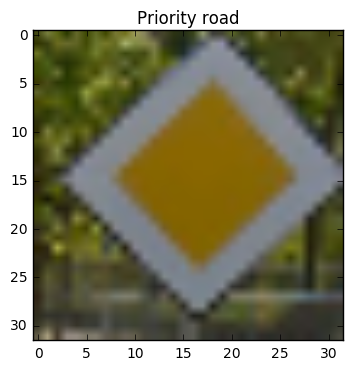

In [8]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
import random

prediction = tf.argmax(tf.nn.softmax(logits), 1)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loader = tf.train.import_meta_graph('lenet.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))

    results = sess.run(prediction, feed_dict={x: list(X_sample)})
    print("Prediction Ids:",results)
    
    for index, result in enumerate(results):
        plt.figure(index+1)
        plt.title(label_dict.get(str(result)))
        plt.imshow(X_sample[index])
    
    plt.show()
    
    

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [16]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
import random

evaluation = tf.nn.top_k(tf.nn.softmax(logits), k=3)

def as_percentage(val):
    return "{0:.0f}%".format(val * 100)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loader = tf.train.import_meta_graph('lenet.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))

    results = sess.run(evaluation, feed_dict={x: list(X_sample)})
    
    for i,row in enumerate(results.values):
        
        indices = results.indices[i]
        
        print(label_dict.get(str(indices[0])),":",as_percentage(row[0]),","
              ,label_dict.get(str(indices[1])),":",as_percentage(row[1]),","
              ,label_dict.get(str(indices[2])),":",as_percentage(row[2]))
    
    

Stop : 100% , No entry : 0% , Speed limit (20km/h) : 0%
Speed limit (70km/h) : 30% , Keep left : 16% , Roundabout mandatory : 12%
Speed limit (30km/h) : 97% , Speed limit (70km/h) : 1% , Speed limit (20km/h) : 1%
Yield : 91% , Children crossing : 4% , Speed limit (60km/h) : 2%
No entry : 100% , Speed limit (70km/h) : 0% , No vehicles : 0%
Turn right ahead : 100% , Keep left : 0% , Go straight or left : 0%
Roundabout mandatory : 100% , Turn left ahead : 0% , Speed limit (120km/h) : 0%
Priority road : 100% , Right-of-way at the next intersection : 0% , Traffic signals : 0%


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.